# Density Wave

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mpc
import matplotlib as mpl
import pint
import scipy.optimize as spo
import scipy.spatial as spa
import pandas as pd
from tqdm import tqdm_notebook

idx = pd.IndexSlice
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


Text(0, 0.5, '$\\mu$m')

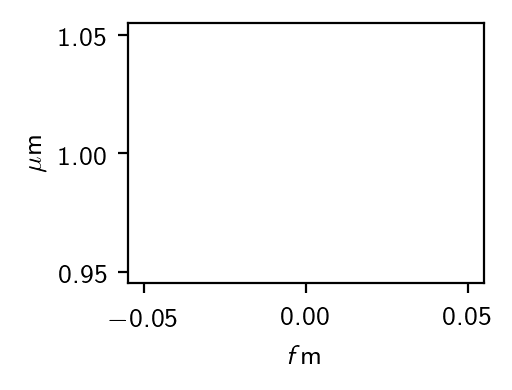

In [13]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

fig, ax = plt.subplots(1,1,figsize=(column-0.5*ureg.cm).to(ureg.inch).magnitude*np.array([1,0.75])/3)

plt.plot([0,0],[1,1])
plt.xlabel(r"$f$m")
plt.ylabel(r"$\mu$m")

In [3]:
#Loading the tracking matrix from csv file 
filePath = "Coordinates_Test45_20190426.dat"
trj = pd.read_csv(filePath ,sep = "\t", index_col=[0, 1])
trj.sort_index()
trj.head()

x           y         x0          y0           r  \
frame particle                                                              
0     0         352.920706  139.925122 -14.158026 -151.137850  151.799537   
      1         365.651232  442.731303  -1.427501  151.668332  151.675049   
      2         399.100464  439.501763  32.021732  148.438791  151.853436   
      3         329.401601  438.292148 -37.677131  147.229177  151.973671   
      4         429.267865  429.774265  62.189132  138.711293  152.014180   

                   theta  time  theta_prime  theta_prime_unwrap  \
frame particle                                                    
0     0        -1.664200   0.0     4.619085            4.619085   
      1         1.580208   0.0     1.580070            1.580070   
      2         1.358329   0.0     1.358189            1.358189   
      3         1.821328   0.0     1.821489            1.821489   
      4         1.149328   0.0     1.149075            1.149075   

                d_theta_prime  theta_dot_prime  
frame particle                                  
0     0                   NaN              NaN  
      1                   NaN              NaN  
      2                   NaN              NaN  
      3                   NaN              NaN  
      4                   NaN              NaN

(197.95724052254423, 536.9981668914947, 119.86569620578717, 460.4519903070701)

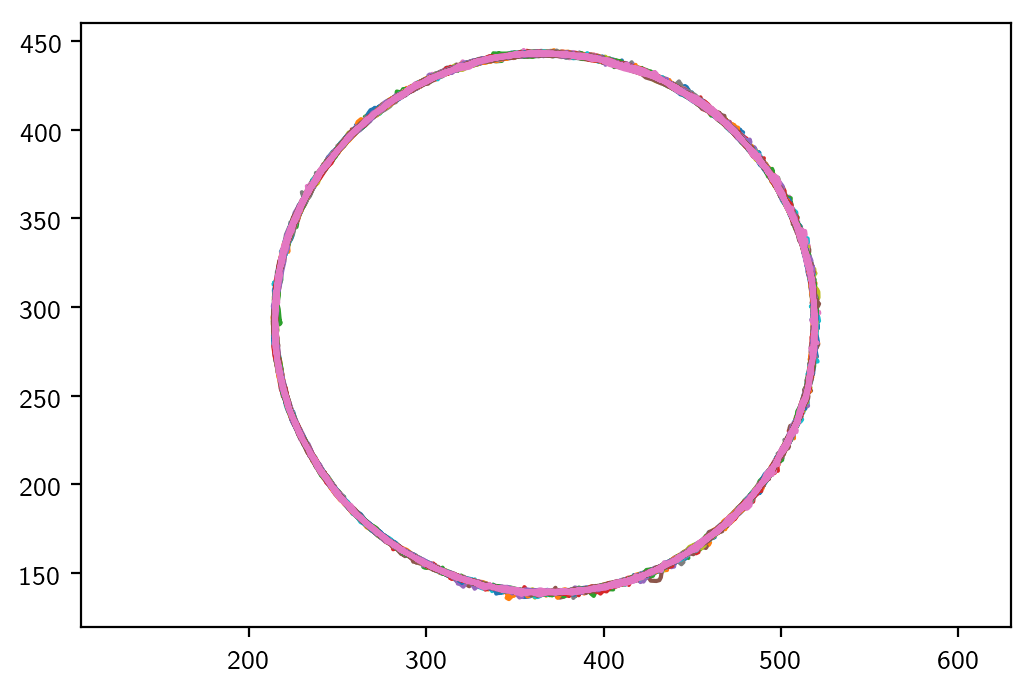

In [4]:
for part,trj_sub in trj.groupby("particle"):
    plt.plot(trj_sub.x,trj_sub.y)
plt.axis("equal")

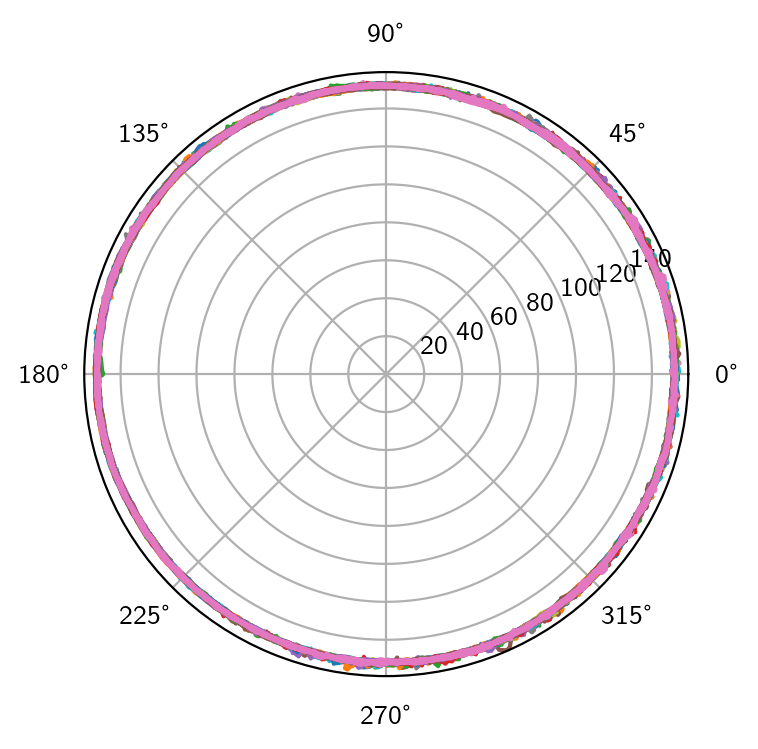

In [5]:
for part,trj_sub in trj.groupby("particle"):
    plt.polar(trj_sub.theta,trj_sub.r)

(15, 40)

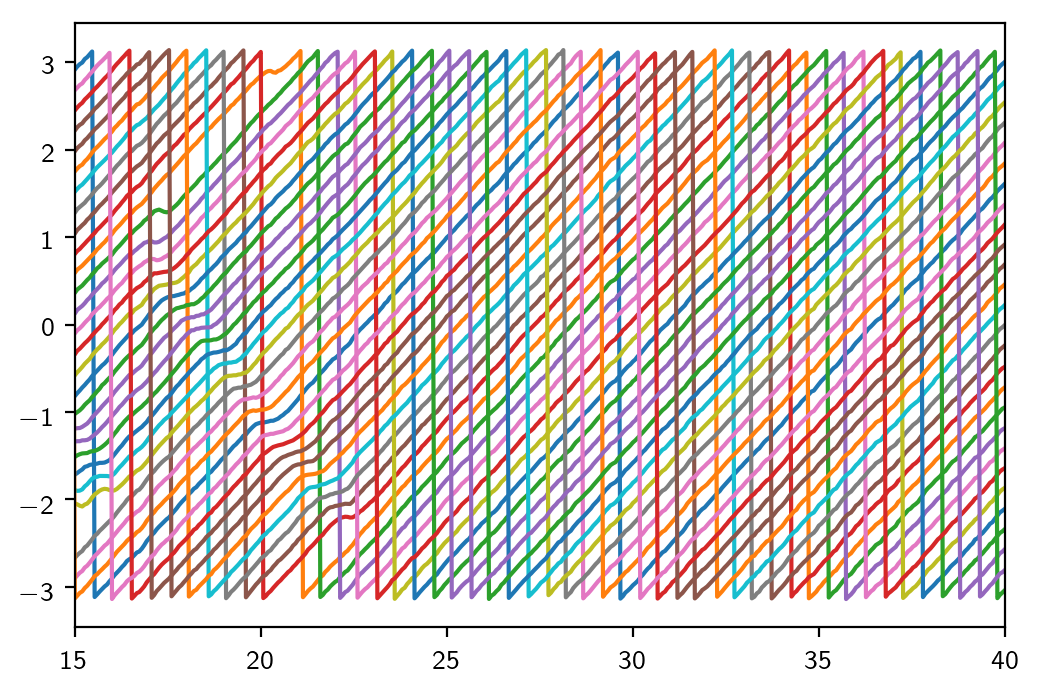

In [6]:
for part,trj_sub in trj.groupby("particle"):
    plt.plot(trj_sub.time,trj_sub.theta)

plt.xlim([15,40])

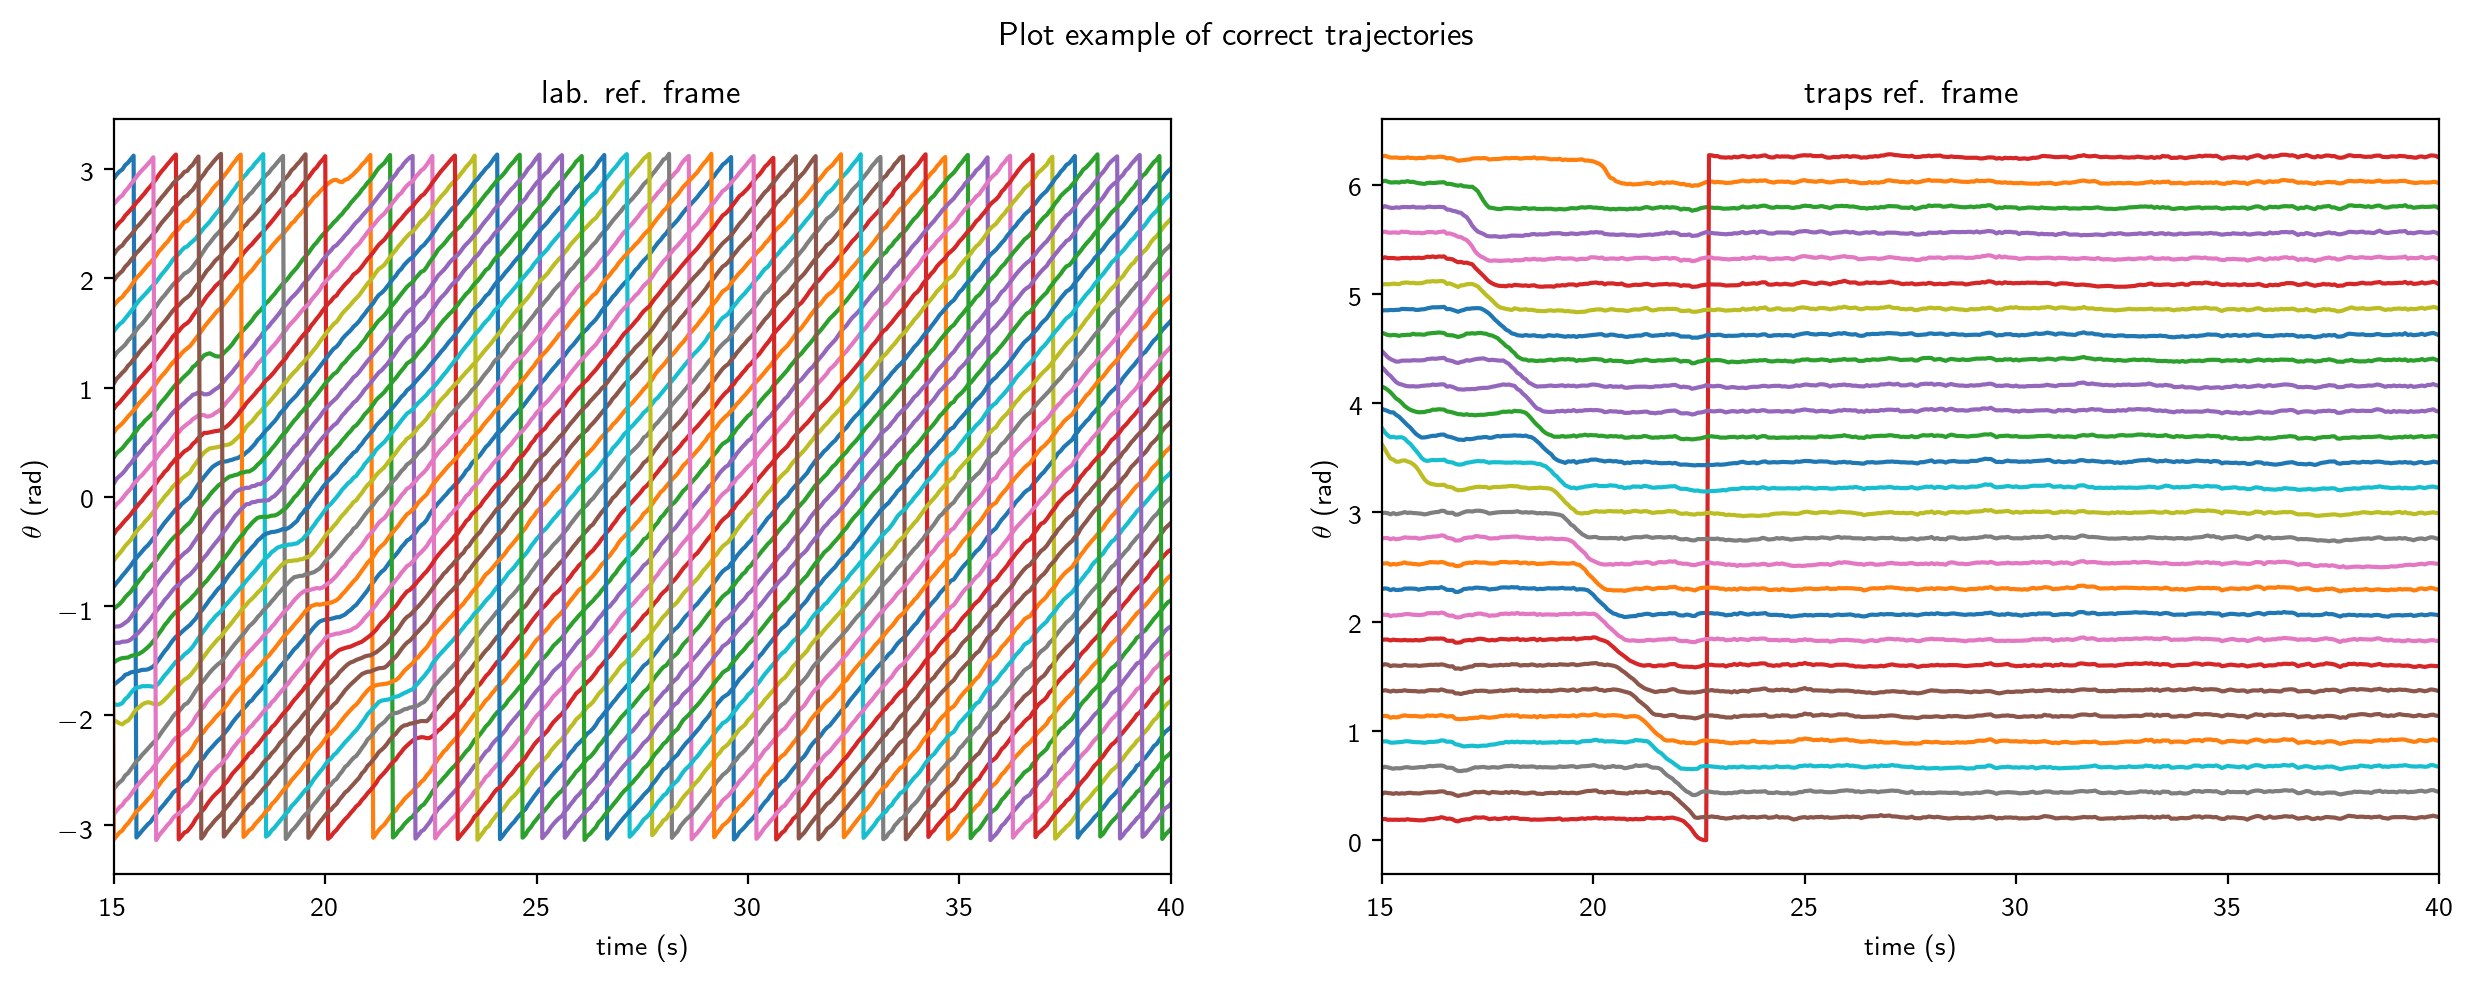

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

for part,trj_sub in trj.groupby("particle"):
    ax[0].plot(trj_sub.time,trj_sub.theta)
    ax[1].plot(trj_sub.time,trj_sub.theta_prime)
    
ax[0].set_xlim([15,40])
ax[0].set_title("lab. ref. frame")
ax[1].set_xlim([15,40])
ax[1].set_title("traps ref. frame")

ax[0].set_xlabel("time (s)")
ax[1].set_xlabel("time (s)")
ax[0].set_ylabel(r"$\theta$ (rad)")
ax[1].set_ylabel(r"$\theta$ (rad)")

fig.suptitle("Plot example of correct trajectories")

fig.savefig('Exp_Good_Trajectories.png', 
            pad_inches = 0,
            bbox_inches = "tight")

Text(0.5, 1.0, 'traps ref. frame')

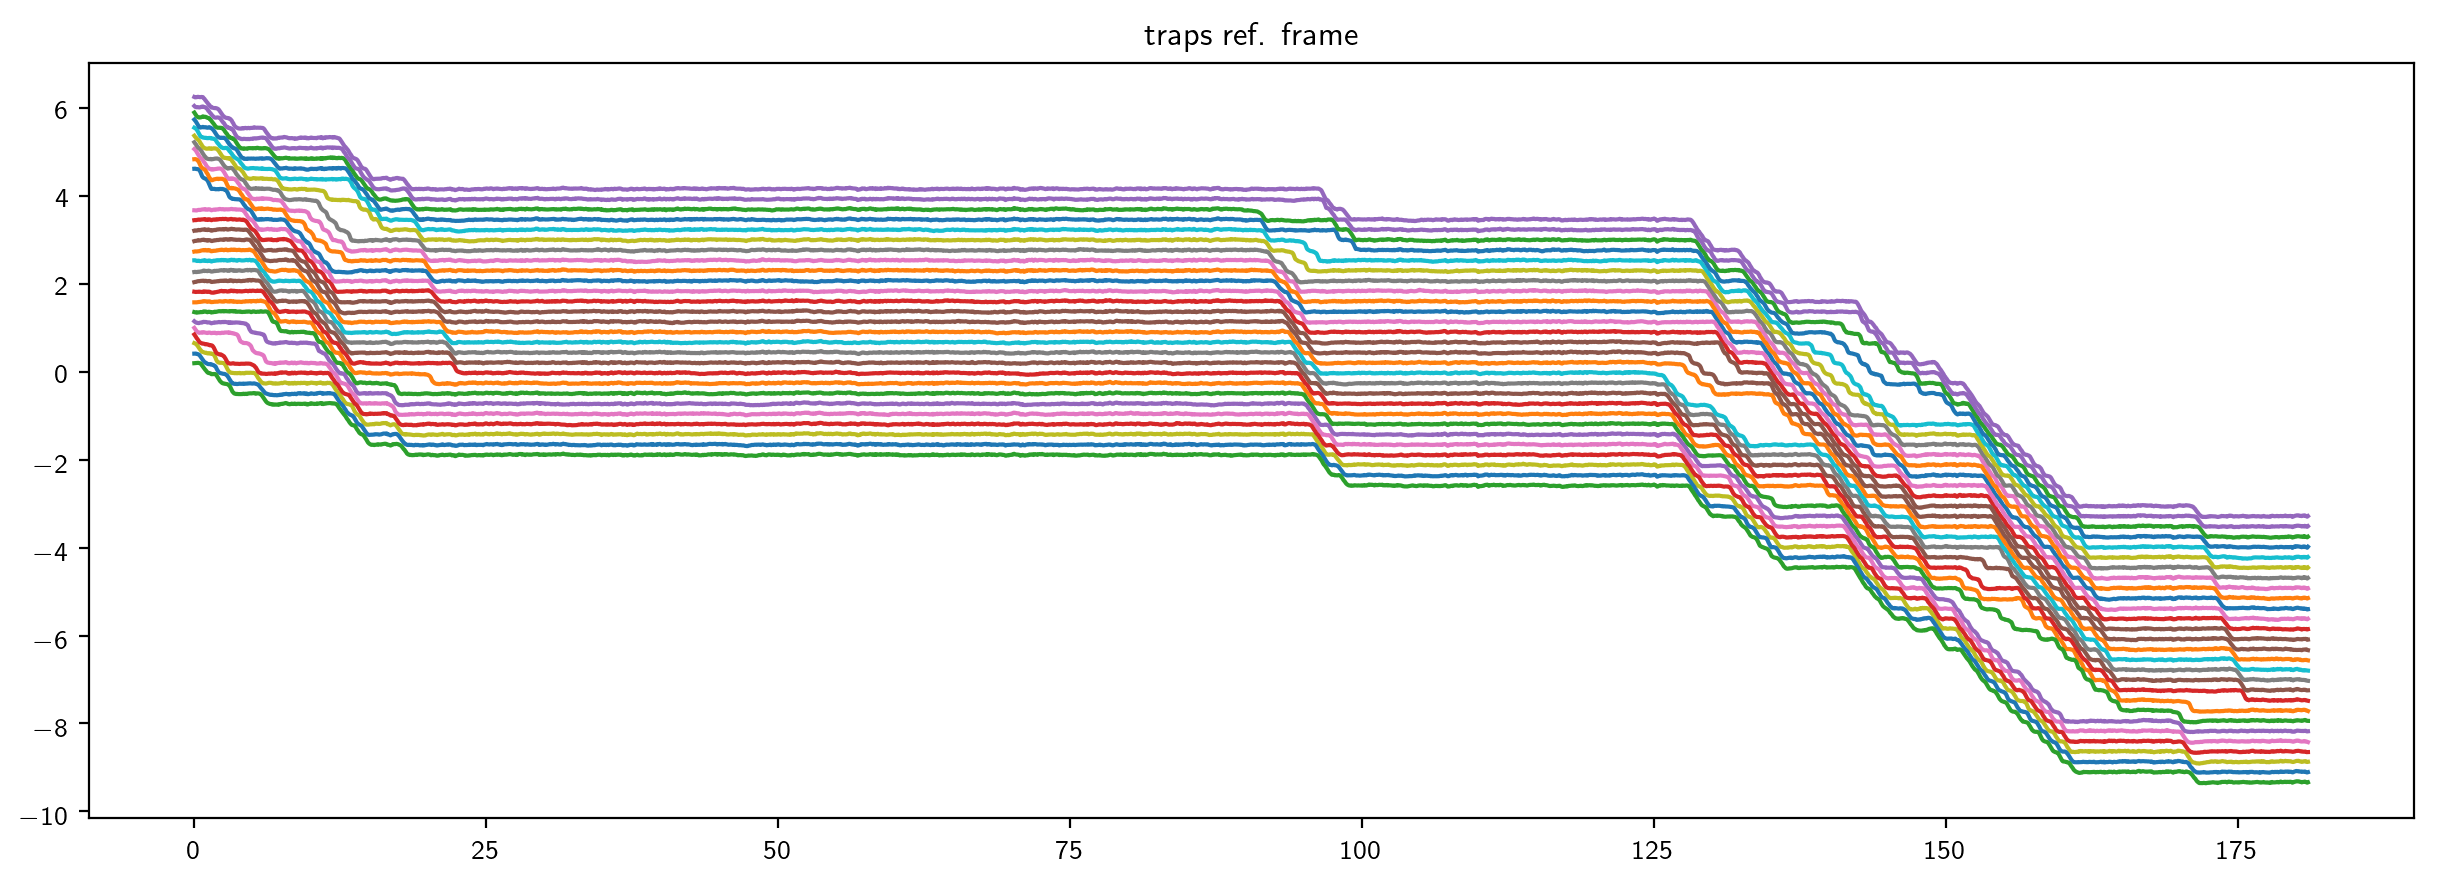

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
for part,trj_sub in trj.groupby("particle"):
    ax.plot(trj_sub.time,np.unwrap(trj_sub.theta_prime))

ax.set_title("traps ref. frame") 
#plt.xlim([15,40])

## Sort particles in the circle

In [9]:
trj.index.names = ["frame","id"]

In [10]:
def sort_particles_in_circle(trj):
    
    # The new id will replace the old particle id. They are the same, except the new one is sorted by increasing angle. 
    
    new_id = trj.loc[idx[0,:],:].sort_values("theta").filter(["theta"])
    new_id["id"] = range(0,len(new_id))
    new_id = new_id.sort_index()
    
    trj.index = trj.index.set_levels(new_id.id.values,level = 1)
    
    return trj.sort_index()

In [11]:
trj = sort_particles_in_circle(trj)

In [12]:
trj.head()

x           y          x0          y0           r  \
frame id                                                               
0     0   215.261814  280.321598 -151.816918  -10.741374  152.196431   
      1   221.423860  244.641632 -145.654872  -46.421339  152.873420   
      2   236.914126  214.357568 -130.164606  -76.705403  151.084558   
      3   352.920706  139.925122  -14.158026 -151.137850  151.799537   
      4   385.818861  140.632928   18.740128 -150.430044  151.592845   

             theta  time  theta_prime  theta_prime_unwrap  d_theta_prime  \
frame id                                                                   
0     0  -3.070958   0.0     3.211943            3.211943            NaN   
      1  -2.833062   0.0     3.449926            3.449926            NaN   
      2  -2.609081   0.0     3.674040            3.674040            NaN   
      3  -1.664200   0.0     4.619085            4.619085            NaN   
      4  -1.446858   0.0     4.836353            4.836353            NaN   

          theta_dot_prime  
frame id                   
0     0               NaN  
      1               NaN  
      2               NaN  
      3               NaN  
      4               NaN

## Calculate distances between neighbors

In [13]:
def calculate_delta(trj, field = "theta"):
    delta = trj[field].copy(deep=True)*np.NaN
    for frm,trj_sub in tqdm_notebook(trj.groupby("frame")):
        A = np.roll(trj_sub[field],1)
        delta.loc[idx[frm,:]] = trj.loc[idx[frm,:],field]-A
        
    delta[abs(delta)>np.pi] = 2*np.pi+delta[abs(delta)>np.pi]
    return delta

trj["delta"] = calculate_delta(trj, field = "theta_prime_unwrap")
trj.head()

x           y          x0          y0           r  \
frame id                                                               
0     0   215.261814  280.321598 -151.816918  -10.741374  152.196431   
      1   221.423860  244.641632 -145.654872  -46.421339  152.873420   
      2   236.914126  214.357568 -130.164606  -76.705403  151.084558   
      3   352.920706  139.925122  -14.158026 -151.137850  151.799537   
      4   385.818861  140.632928   18.740128 -150.430044  151.592845   

             theta  time  theta_prime  theta_prime_unwrap  d_theta_prime  \
frame id                                                                   
0     0  -3.070958   0.0     3.211943            3.211943            NaN   
      1  -2.833062   0.0     3.449926            3.449926            NaN   
      2  -2.609081   0.0     3.674040            3.674040            NaN   
      3  -1.664200   0.0     4.619085            4.619085            NaN   
      4  -1.446858   0.0     4.836353            4.836353            NaN   

          theta_dot_prime     delta  
frame id                             
0     0               NaN  0.238943  
      1               NaN  0.237984  
      2               NaN  0.224114  
      3               NaN  0.945044  
      4               NaN  0.217268

In [14]:
def get_polygons(x,y1,y2,array):
    
    p = [((x[i],y1[i]),(x[i+1],y1[i+1]),(x[i+1],y2[i+1]),(x[i],y2[i]))
        for i,d in enumerate(x[:-2]) if (y1[i]<y2[i])&(y1[i+1]<y2[i+1])]
    array = np.array([array.values[i]
         for i,d in enumerate(x[:-2]) if (y1[i]<y2[i])&(y1[i+1]<y2[i+1])])
    
    return p, array
    
def fill_between_trj(trj, field, color_field, ax = None, **kargs):
    
    if ax is None:
        ax = plt.gca()
        
    polygons = []
    colors = []
    
    for part in tqdm_notebook(trj.index.get_level_values("id").unique()[:-1]):
        
        x = trj.loc[idx[:,part],:].time.values
        y1 = 2*np.pi-trj.loc[idx[:,part],field].values
        y2 = 2*np.pi-trj.loc[idx[:,part+1],field].values
                
        p, c = get_polygons(x,y2,y1,trj.loc[idx[:,part+1],color_field])
        polygons += p
        colors = np.concatenate([colors,c])
        
    x = trj.loc[idx[:,part+1],:].time.values
    y1 = 2*np.pi-trj.loc[idx[:,part+1],field].values
    y2 = 2*np.pi-trj.loc[idx[:,0],field].values
    
    p, c = get_polygons(x,y2,y1,trj.loc[idx[:,0],color_field])
    polygons += p
    colors = np.concatenate([colors,c])
        
    #Poly = ax.add_collection(mpc.PolyCollection(polygons,**kargs))
    #Poly.set_array(colors)
    return polygons, colors

In [15]:
N_traps = 27

distance_between_traps = (2*np.pi)/27

In [16]:
distance_between_traps

0.23271056693257727

In [17]:
import matplotlib as mpl
old_cm_numeric = mpl.cm.seismic(np.linspace(0,1,256)**(1/2))
new_cm = mpl.colors.ListedColormap(old_cm_numeric)

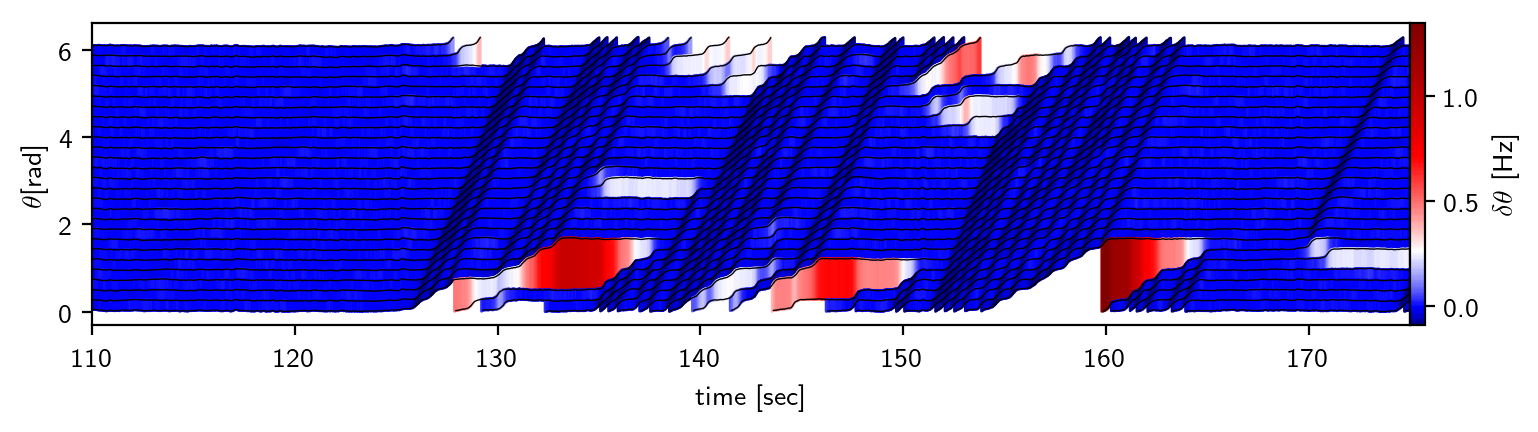

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,2))

field = "theta_prime"

polygons,colors = fill_between_trj(trj, field, "delta")

Poly = ax.add_collection(mpc.PolyCollection(polygons, cmap=new_cm))
colors = colors-distance_between_traps
Poly.set_array(colors)
Poly.set_clim(vmin=min(colors), vmax=max(colors))
Poly.set_edgecolor("face")

y = trj.loc[:,["theta_prime","time"]].copy(deep=True)
y[np.abs(y.groupby("id").diff()["theta_prime"])>np.pi]=np.NaN

for i, y_i in y.groupby("id"):
    plt.plot(y_i.time, 2*np.pi-y_i["theta_prime"],color="black",linewidth = 0.5)

#plt.colorbar(Poly)
axcb = fig.colorbar(Poly, pad=0)
axcb.set_label(r'$\delta \theta$ [Hz]')

plt.xlim([110,175])
#plt.ylim([0,2*np.pi])
plt.xlabel(r"time [sec]")
plt.ylabel(r"$\theta$[rad]");

C:\Users\Eric\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


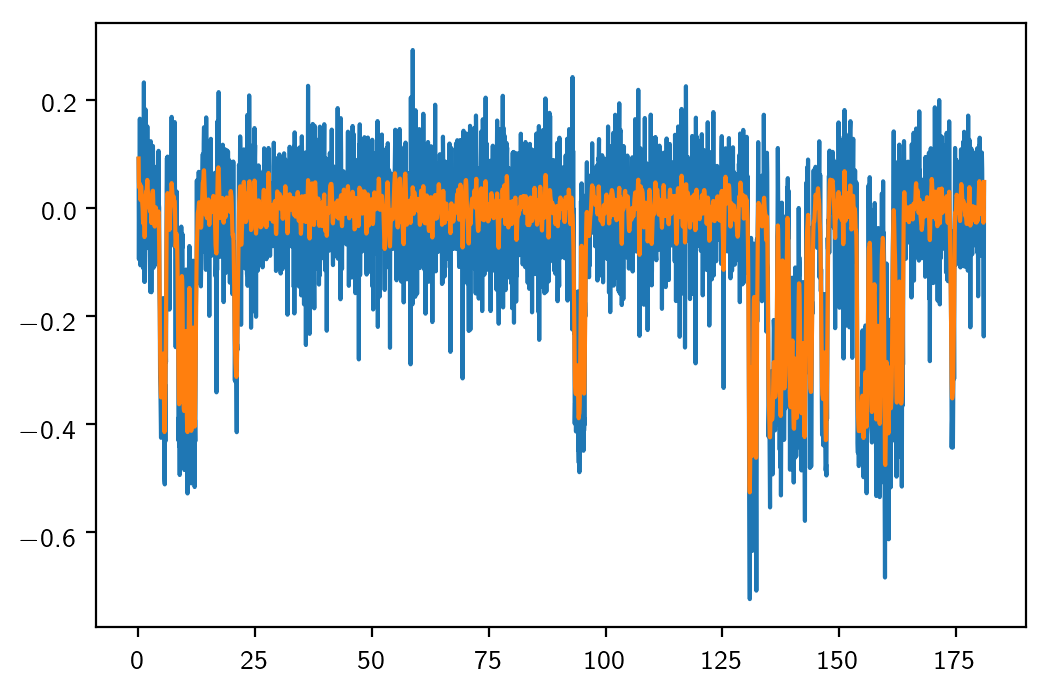

In [19]:
from scipy import signal

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(lowcut, order=5):
    low = lowcut 
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_filter(data, lowcut, order=5):
    b, a = butter_lowpass(lowcut, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_highpass(highcut, order=5):
    high = highcut 
    b, a = signal.butter(order, high, btype='highpass')
    return b, a

def butter_highpass_filter(data, highcut, order=5):
    b, a = butter_highpass(highcut, order=order)
    y = signal.lfilter(b, a, data)
    return y

lowcut = 0.2#500
highcut = 0.8#1250
fs = 5000

#for part,trj_sub in trj.groupby("id"):
    #plt.plot(trj_sub.time, trj_sub.theta_dot_prime)
#y = butter_bandpass_filter(trj.loc[idx[1:,0],:].theta_dot_prime.values, lowcut, highcut, fs, order=6)
y = butter_lowpass_filter(trj.loc[idx[1:,0],:].theta_dot_prime.values, lowcut, order=1)
#y = butter_highpass_filter(trj.loc[idx[1:,0],:].theta_dot_prime.values, highcut, order=6)
plt.plot(trj.loc[idx[:,0],:].time.values, trj.loc[idx[:,0],:].theta_dot_prime.values)
plt.plot(trj.loc[idx[1:,0],:].time.values, y)

#plt.xlim([110, 175])
plt.show()

In [20]:
trj

x           y          x0          y0           r  \
frame id                                                               
0     0   215.261814  280.321598 -151.816918  -10.741374  152.196431   
      1   221.423860  244.641632 -145.654872  -46.421339  152.873420   
      2   236.914126  214.357568 -130.164606  -76.705403  151.084558   
      3   352.920706  139.925122  -14.158026 -151.137850  151.799537   
      4   385.818861  140.632928   18.740128 -150.430044  151.592845   
      5   419.929611  148.410083   52.850879 -142.652888  152.128439   
      6   442.548605  156.110865   75.469872 -134.952107  154.621385   
      7   459.224994  171.734012   92.146261 -119.328959  150.765825   
      8   479.877251  189.925907  112.798519 -101.137065  151.499874   
      9   496.497002  212.403649  129.418270  -78.659323  151.447607   
      10  508.280142  233.718951  141.201410  -57.344021  152.401361   
      11  514.864335  255.494612  147.785603  -35.568359  152.005567   
      12  518.711668  286.328752  151.632936   -4.734219  151.706823   
      13  515.710609  320.528668  148.631877   29.465697  151.524461   
      14  506.317200  352.140002  139.238468   61.077030  152.045238   
      15  487.442582  382.952591  120.363850   91.889619  151.430375   
      16  467.626286  405.046433  100.547554  113.983462  151.993553   
      17  449.760559  419.564875   82.681826  128.501904  152.803873   
      18  429.267865  429.774265   62.189132  138.711293  152.014180   
      19  399.100464  439.501763   32.021732  148.438791  151.853436   
      20  365.651232  442.731303   -1.427501  151.668332  151.675049   
      21  329.401601  438.292148  -37.677131  147.229177  151.973671   
      22  298.018864  427.371938  -69.059868  136.308966  152.805104   
      23  268.762817  407.795206  -98.315915  116.732235  152.618589   
      24  242.241312  377.375220 -124.837420   86.312248  151.770174   
      25  226.826136  351.427401 -140.252597   60.364430  152.691373   
      26  217.137107  316.600355 -149.941626   25.537383  152.100786   
1     0   215.676162  274.717895 -151.402571  -16.345076  152.282303   
      1   223.274792  239.755394 -143.803940  -51.307578  152.682811   
      2   238.409996  210.219298 -128.668736  -80.843673  151.958360   
...              ...         ...         ...         ...         ...   
2714  24  444.714489  422.397778   77.635757  131.334806  152.565206   
      25  412.154549  436.337213   45.075816  145.274242  152.106655   
      26  377.534143  443.457490   10.455411  152.394518  152.752757   
2715  0   337.253945  439.307183  -29.824787  148.244211  151.214629   
      1   303.427119  428.241427  -63.651613  137.178456  151.226507   
      2   272.468917  409.979426  -94.609815  118.916455  151.960983   
      3   249.191272  386.799416 -117.887460   95.736444  151.864808   
      4   229.107647  354.273664 -137.971086   63.210692  151.761695   
      5   217.718069  322.675402 -149.360663   31.612431  152.669426   
      6   215.024739  286.427066 -152.053993   -4.635905  152.124648   
      7   219.902943  250.950364 -147.175789  -40.112607  152.544204   
      8   234.460415  217.680507 -132.618317  -73.382465  151.567161   
      9   255.567366  189.216182 -111.511367 -101.846789  151.021698   
      10  281.265763  166.264505  -85.812970 -124.798466  151.454690   
      11  313.366487  149.601039  -53.712245 -141.461932  151.315840   
      12  346.835440  139.724409  -20.243293 -151.338563  152.686448   
      13  381.323753  139.232220   14.245021 -151.830752  152.497534   
      14  415.646529  146.682349   48.567797 -144.380623  152.330546   
      15  448.653122  160.994874   81.574390 -130.068097  153.532052   
      16  474.460333  182.999642  107.381601 -108.063330  152.343334   
      17  496.025222  209.895787  128.946490  -81.167184  152.365708   
      18  511.543338  243.861233  144.464605  -47.201738  151.980348   
      19  518.227569  279.152891  151.148837  -11.910081  1

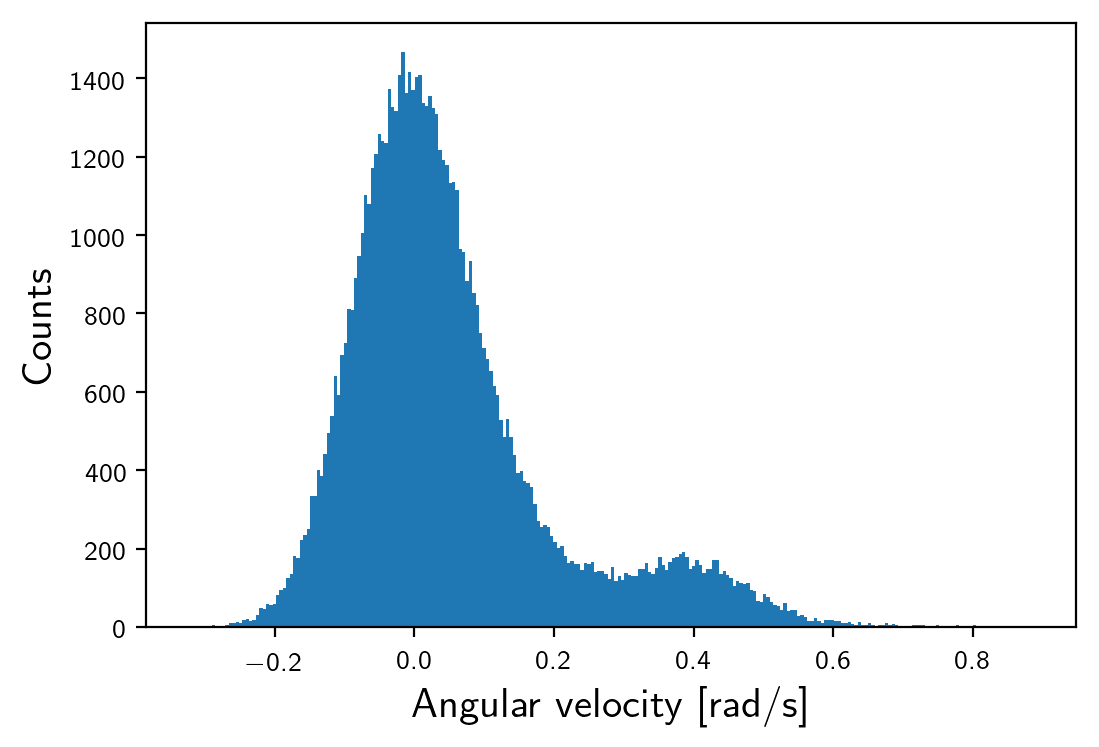

In [30]:
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
from pylab import *

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

#y,x,_
#y, bins, patches = 
plt.hist(-trj.loc[idx[1:,:],"theta_dot_prime"],250)#, alpha = .3, label='data')
plt.xlabel("Angular velocity [rad/s]", fontfamily="sans-serif",  fontsize=15)
plt.ylabel("Counts", fontfamily="sans-serif",  fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
#bins=(bins[1:]+bins[:-1])/2 #to have the same value of bins

#expected = (0,.05,35000, .4,.1,500)
#params, cov = curve_fit(bimodal, bins, y, expected)
#sigma = sqrt(diag(cov))
#plot(bins, bimodal(bins, *params), color='red', lw=3, label='model')
#print(params,'\n',sigma)

#(mu, sigma) = norm.fit(-trj.loc[idx[1:,:],"theta_dot_prime"])
#n, bins, patches = plt.hist(-trj.loc[idx[1:,:],"theta_dot_prime"], bins = 500)

#hist_fit = mlab.normpdf(bins, mu, sigma)
#plt.plot(bins, hist_fit, 'r--')
#plt.show()

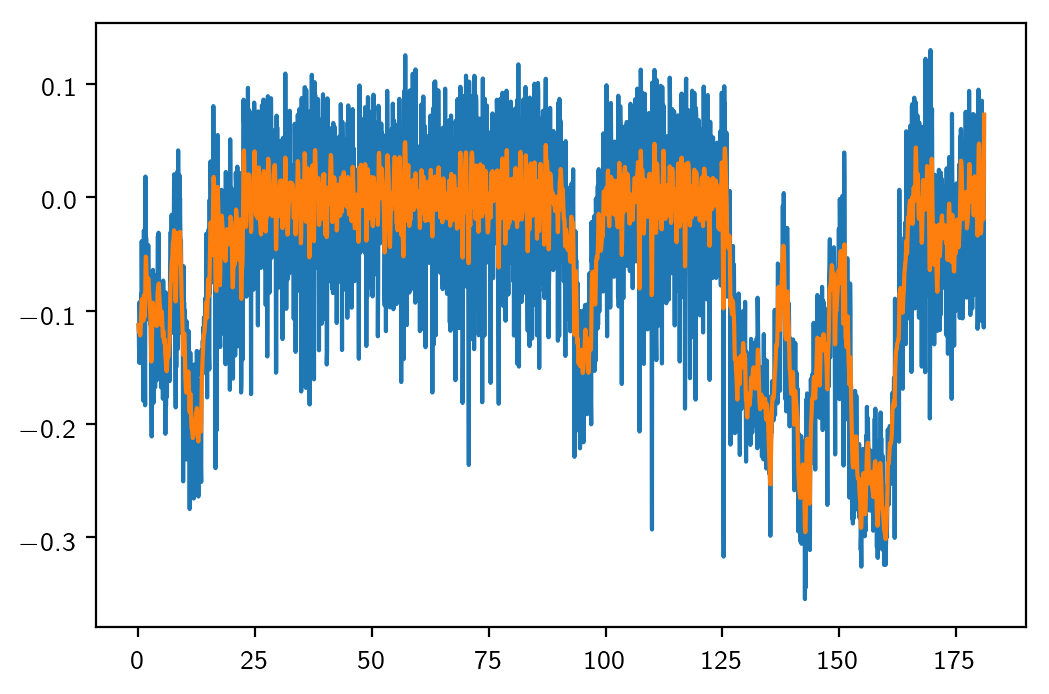

In [22]:
foo = []
for frame, tr_sub in trj.groupby("frame"):
    if frame != 0:
        foo.append(tr_sub.theta_dot_prime.mean())
        
y_foo = butter_lowpass_filter(foo, lowcut, order=1)

plt.plot(trj.loc[idx[1:,part],:].time.values, foo)
plt.plot(trj.loc[idx[1:,part],:].time.values, y_foo)
#plt.xlim([110, 175])
plt.show()

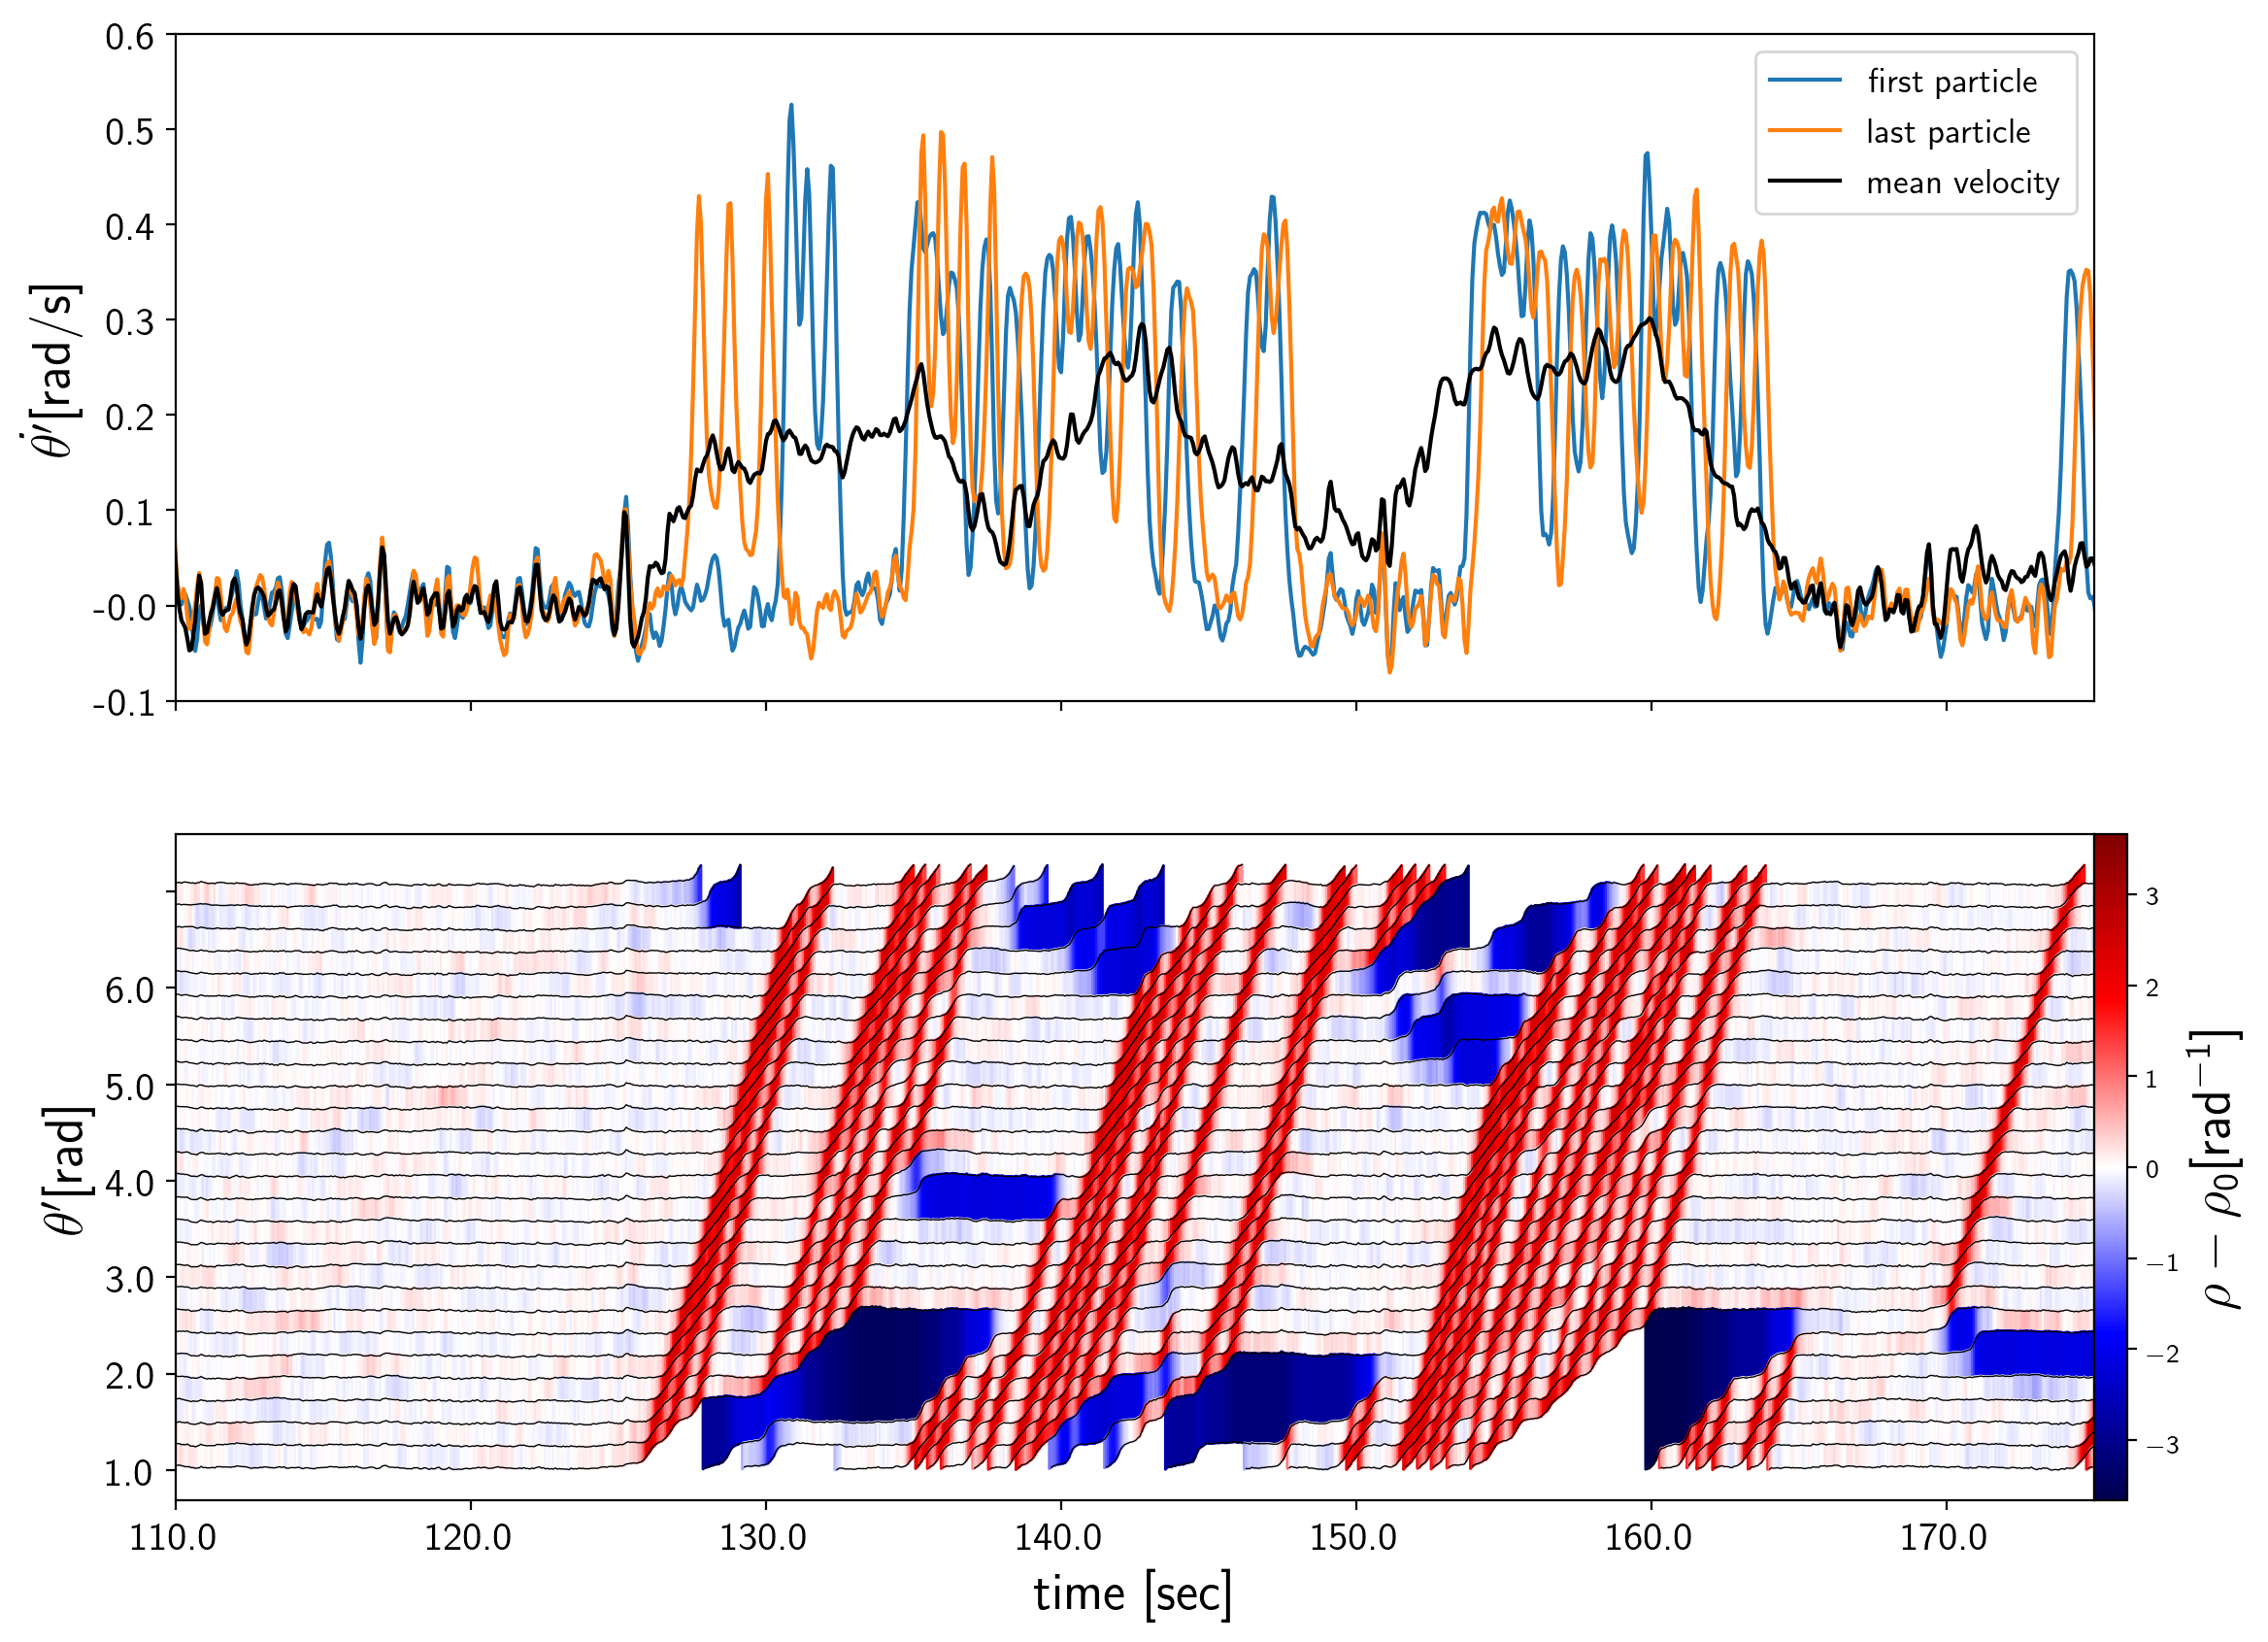

In [29]:
fig, ax = plt.subplots(2,1,figsize=(15,10), sharex=True)

xilim = 110
xslim = 175

lowcut = 0.2

#for part,trj_sub in trj.groupby("id"):
#    y = butter_lowpass_filter(trj.loc[idx[1:,part],:].theta_dot_prime.values, lowcut, order=1)
#    ax[0].plot(trj.loc[idx[1:,part],:].time.values, -y, label="particle{}".format(part))

#Only plot of 3 velocities in order to not saturate the velocity graph
y = butter_lowpass_filter(trj.loc[idx[1:,0],:].theta_dot_prime.values, lowcut, order=1)
ax[0].plot(trj.loc[idx[1:,0],:].time.values, -y, label="first particle")

#y = butter_lowpass_filter(trj.loc[idx[1:,14],:].theta_dot_prime.values, lowcut, order=1)
#ax[0].plot(trj.loc[idx[1:,14],:].time.values, -y, label="middle particle")

y = butter_lowpass_filter(trj.loc[idx[1:,25],:].theta_dot_prime.values, lowcut, order=1)
ax[0].plot(trj.loc[idx[1:,25],:].time.values, -y, label="last particle")

ax[0].plot(trj.loc[idx[1:,part],:].time.values, -y_foo, label='mean velocity', color='black')
#ax[0].set_xlabel(r"time [sec]")
ax[0].set_ylabel(r"$\dot{\theta'} $[rad/s]", fontfamily="sans-serif",  fontsize=20);
ax[0].set_xlim([xilim,xslim])
ax[0].set_ylim([-0.1, 0.6])

ax[0].legend(fontsize=13)


field = "theta_prime"

polygons,colors = fill_between_trj(trj, field, "delta")

Poly = ax[1].add_collection(mpc.PolyCollection(polygons, cmap="seismic"))
colors = 1/(colors)-1/distance_between_traps
Poly.set_array(colors)
Poly.set_clim(vmin=min(colors), vmax=-min(colors))
Poly.set_edgecolor("face")

y = trj.loc[:,["theta_prime","time"]].copy(deep=True)
y[np.abs(y.groupby("id").diff()["theta_prime"])>np.pi]=np.NaN

for i, y_i in y.groupby("id"):
    ax[1].plot(y_i.time.values, 2*np.pi-y_i["theta_prime"], color="black", linewidth = 0.5)

#plt.colorbar(Poly)
axcb = fig.colorbar(Poly, pad=0)
axcb.set_label(r'$\rho-\rho_0$[rad$^{-1}$]', fontfamily="sans-serif",  fontsize=20)

ax[1].set_xlim([xilim,xslim])
#ax[1].ylim([0,2*np.pi])
ax[1].set_xlabel(r"time [sec]", fontfamily="sans-serif",  fontsize=20)
ax[1].set_ylabel(r"$\theta' $[rad]", fontfamily="sans-serif",  fontsize=20);

pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[0].set_position([pos2.x0,pos.y0,pos2.width,pos.height])

x_ticks = np.linspace(xilim, 170, 7)
y_ticks1 = np.around(np.linspace(-0.1, 0.6, 8), 1)
y_ticks2 = np.linspace(0, 6, 7)
ax[0].set_yticklabels(y_ticks1, rotation=0, fontsize=15)
ax[1].set_xticklabels(x_ticks, rotation=0, fontsize=15)
ax[1].set_yticklabels(y_ticks2, rotation=0, fontsize=15);
#fig.savefig('D:/Dropbox/Colloids/BASEP/ScriptsEric/Density_Waves1.pdf', 
#            pad_inches = 0,
#            bbox_inches = "tight")